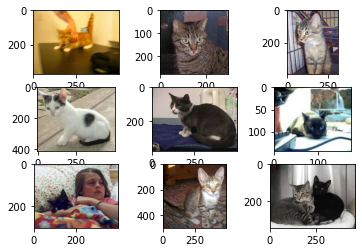

In [4]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train/train/'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'cat.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [5]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [14]:
TRAIN_DIR = 'train/train/'
#
TEST_DIR = 'test1/test1/'
IMG_SIZE = 50 #For resizing the images
LR = 1e-3
MODEL_NAME = 'dogsvsacats-{}-{}.model'.format(LR, '2conv-basic')

In [15]:
import tensorflow

In [16]:
#OHE
#cat.567.png
def label_img(img):
    word_label = img.split('.')[-3] #gets cat and dog label
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [17]:
def create_train_data():
  training_data = []
  for img in tqdm(os.listdir(TRAIN_DIR)):
    label = label_img(img)
    path = os.path.join(TRAIN_DIR, img)
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
    training_data.append([np.array(img), np.array(label)])
  shuffle(training_data)
  np.save('train_data.npy', training_data)
  return training_data

In [18]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [19]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [03:28<00:00, 119.87it/s]


In [28]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf
tf.reset_default_graph()

import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('C:/Users/H/Desktop/KaggleDogsvsCats/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 3829  | total loss: 0.35936 | time: 32.367s
| Adam | epoch: 010 | loss: 0.35936 - acc: 0.8440 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.35154 | time: 33.452s
| Adam | epoch: 010 | loss: 0.35154 - acc: 0.8518 | val_loss: 0.50304 - val_acc: 0.7720 -- iter: 24500/24500
--
INFO:tensorflow:C:\Users\Gokuul\Desktop\ML\ComputerVision\catsdogs\dogsvsacats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [03:52<00:00, 53.78it/s]


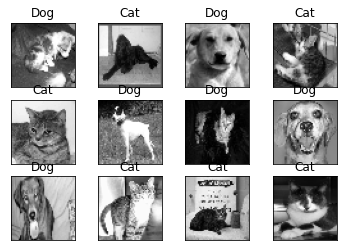

In [32]:
import matplotlib.pyplot as plt
# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()